<a href="https://colab.research.google.com/github/jungeun202/Transformer/blob/main/Transformer_translation_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
text_file = "/content/drive/MyDrive/spa.txt"

In [ ]:

with open(text_file) as f:
    lines = f.read().split("\n")[:1600]

text_pairs = []
for line in lines:
    parts = line.split("\t")
    if len(parts) >= 2:  # Ensure there are at least two elements
        eng = parts[0]
        spa = parts[1]
        spa = "[start] " + spa + " [end]"
        text_pairs.append((eng, spa))

# Now text_pairs contains the processed text pairs
print(text_pairs)


[('Go.', '[start] Ve. [end]'), ('Go.', '[start] Vete. [end]'), ('Go.', '[start] Vaya. [end]'), ('Go.', '[start] Váyase. [end]'), ('Hi.', '[start] Hola. [end]'), ('Run!', '[start] ¡Corre! [end]'), ('Run!', '[start] ¡Corran! [end]'), ('Run!', '[start] ¡Huye! [end]'), ('Run!', '[start] ¡Corra! [end]'), ('Run!', '[start] ¡Corred! [end]'), ('Run.', '[start] Corra. [end]'), ('Run.', '[start] Corred. [end]'), ('Who?', '[start] ¿Quién? [end]'), ('Wow!', '[start] ¡Órale! [end]'), ('Duck!', '[start] ¡Inclínate! [end]'), ('Duck!', '[start] ¡Agáchate! [end]'), ('Duck!', '[start] ¡Agáchese! [end]'), ('Duck!', '[start] ¡Agáchense! [end]'), ('Duck!', '[start] ¡Agachaos! [end]'), ('Fire!', '[start] ¡Fuego! [end]'), ('Fire!', '[start] ¡Incendio! [end]'), ('Fire!', '[start] ¡Disparad! [end]'), ('Help!', '[start] ¡Ayuda! [end]'), ('Help!', '[start] ¡Socorro! ¡Auxilio! [end]'), ('Help!', '[start] ¡Auxilio! [end]'), ('Hide.', '[start] Escóndete. [end]'), ('Jump!', '[start] ¡Salta! [end]'), ('Jump.', '[star

In [ ]:
import random

In [ ]:
for _ in range(5):
    print(random.choice(text_pairs))

('Be brief.', '[start] Sean breves. [end]')
('Tom bowed.', '[start] Tom se inclinó. [end]')
('Hold it.', '[start] Sujétalo. [end]')
('Come over.', '[start] Vente. [end]')
("I'm hiding.", '[start] Yo estoy escondido. [end]')


In [ ]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

1600 total pairs
1120 training pairs
240 validation pairs
240 test pairs


In [ ]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

import keras
from keras import layers
from keras.layers import TextVectorization

In [ ]:
strip_chars = string.punctuation + "¿" # the inverted question mark is for spanish
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
# remove all special characters

batch_size = 32 # the number of samples to process at once during training.

all_texts = [pair[0] for pair in text_pairs] + [pair[1] for pair in text_pairs]
unique_tokens = set()
for text in all_texts:
    unique_tokens.update(text.split())
vocab_size = len(unique_tokens)

print("vocab_size: " , vocab_size)

def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)  # Convert to lowercase
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")  # Remove punctuation


vocab_size:  2282


In [ ]:
def format_dataset(eng, spa): # takes eng and spa text pairs as input
# English texts are fed to the encoder and Spanish texts are fed to the decoder
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": spa[:, :-1], # exclude the last token ; used it as input to the decorder during training
        },
        spa[:, 1:], # Spanish texts excluding the first token; target output for the decorder
    )


def make_dataset(pairs): # takes a list of text pairs and prepares tensorflow dataset
    eng_texts, spa_texts = zip(*pairs) # split pairs
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, spa_texts)) # creates a dataset
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)


In [ ]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_

# Custom transformer model code
class Embeddings(nn.Module):
    def __init__(self, vocab_num, d_model):
        super(Embeddings, self).__init__()
        self.emb = nn.Embedding(vocab_num, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.emb(x) * math.sqrt(self.d_model)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int = 80, max_length: int = 5000) -> None:
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_length, d_model, requires_grad=False)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, length: int) -> torch.Tensor:
        return self.pe[:, :length]

def self_attention(query, key, value, mask=None):
    key_transpose = torch.transpose(key, -2, -1)
    matmul_result = torch.matmul(query, key_transpose)
    d_k = query.size()[-1]
    attention_score = matmul_result / math.sqrt(d_k)
    if mask is not None:
        attention_score = attention_score.masked_fill(mask == 0, -1e20)
    softmax_attention_score = F.softmax(attention_score, dim=-1)
    result = torch.matmul(softmax_attention_score, value)
    return result, softmax_attention_score

class MultiHeadAttention(nn.Module):
    def __init__(self, head_num, d_model, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % head_num == 0
        self.head_num = head_num
        self.d_model = d_model
        self.d_k = self.d_v = d_model // head_num
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        self.self_attention = self_attention
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        batch_num = query.size(0)
        query = self.w_q(query).view(batch_num, -1, self.head_num, self.d_k).transpose(1, 2)
        key = self.w_k(key).view(batch_num, -1, self.head_num, self.d_k).transpose(1, 2)
        value = self.w_v(value).view(batch_num, -1, self.head_num, self.d_k).transpose(1, 2)
        attention_result, attention_score = self.self_attention(query, key, value, mask)
        attention_result = attention_result.transpose(1, 2).contiguous().view(batch_num, -1, self.head_num * self.d_k)
        return self.w_o(attention_result)

class FeedForward(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super(FeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_model * 4)
        self.w_2 = nn.Linear(d_model * 4, d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

class Encoder(nn.Module):
    def __init__(self, d_model, head_num, dropout):
        super(Encoder, self).__init__()
        self.multi_head_attention = MultiHeadAttention(d_model=d_model, head_num=head_num)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.feed_forward = FeedForward(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)

    def forward(self, input, mask):
        out = self.layer_norm1(input + self.multi_head_attention(input, input, input, mask))
        out = self.layer_norm2(out + self.feed_forward(out))
        return out

class Decoder(nn.Module):
    def __init__(self, d_model, head_num, dropout):
        super(Decoder, self).__init__()
        self.masked_multi_head_attention = MultiHeadAttention(d_model=d_model, head_num=head_num)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.encoder_decoder_attention = MultiHeadAttention(d_model=d_model, head_num=head_num)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.feed_forward = FeedForward(d_model)
        self.layer_norm3 = nn.LayerNorm(d_model)

    def forward(self, target, encoder_output, target_mask, encoder_mask):
        x = self.layer_norm1(target + self.masked_multi_head_attention(target, target, target, target_mask))
        x = self.layer_norm2(x + self.encoder_decoder_attention(x, encoder_output, encoder_output, encoder_mask))
        x = self.layer_norm3(x + self.feed_forward(x))
        return x

def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class TransformerLM(nn.Module):
    def __init__(self, vocab_size, dim, depth, max_seq_len, head_num, dropout=0.1):
        super(TransformerLM, self).__init__()
        self.token_emb = nn.Embedding(vocab_size, dim)
        self.position_emb = PositionalEncoding(dim, max_seq_len)
        self.encoders = clones(Encoder(d_model=dim, head_num=head_num, dropout=dropout), depth)
        self.norm = nn.LayerNorm(dim)
        self.lm_head = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Linear(dim, vocab_size)
        )

    def subsequent_mask(self, size):
        attn_shape = (1, size, size)
        subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
        return torch.from_numpy(subsequent_mask) == 0

    def forward(self, input_ids, input_mask=None):
        max_seq_len = input_ids.size(1)
        if input_mask is None:
            input_mask = self.subsequent_mask(max_seq_len).to(input_ids.device)
        x = self.token_emb(input_ids)
        x = x + self.position_emb(max_seq_len).type_as(x)
        for encoder in self.encoders:
            x = encoder(x, input_mask)
        x = self.norm(x)
        return self.lm_head(x)


Sequence Length: 1, Num Batches: 100
Epoch 1/20, Loss: 7.708566098213196
Epoch 2/20, Loss: 7.3397639989852905
Epoch 3/20, Loss: 7.039821929931641
Epoch 4/20, Loss: 6.737771530151367
Epoch 5/20, Loss: 6.383725428581238
Epoch 6/20, Loss: 5.965786638259888
Epoch 7/20, Loss: 5.501192469596862
Epoch 8/20, Loss: 5.000750484466553
Epoch 9/20, Loss: 4.485473895072937
Epoch 10/20, Loss: 3.9632587122917173
Epoch 11/20, Loss: 3.4642330622673034
Epoch 12/20, Loss: 2.9979570364952086
Epoch 13/20, Loss: 2.5830386686325073
Epoch 14/20, Loss: 2.22926381111145
Epoch 15/20, Loss: 1.937943572998047
Epoch 16/20, Loss: 1.717326258420944
Epoch 17/20, Loss: 1.5377064216136933
Epoch 18/20, Loss: 1.4230435997247697
Epoch 19/20, Loss: 1.3331786793470384
Epoch 20/20, Loss: 1.29046082675457
Sequence Length: 1, Avg Loss: 4.032013156145811, Time: 31.076865434646606
Sequence Length: 2, Num Batches: 100
Epoch 1/20, Loss: 7.709867281913757
Epoch 2/20, Loss: 7.496090798377991
Epoch 3/20, Loss: 7.293152952194214
Epoch 4

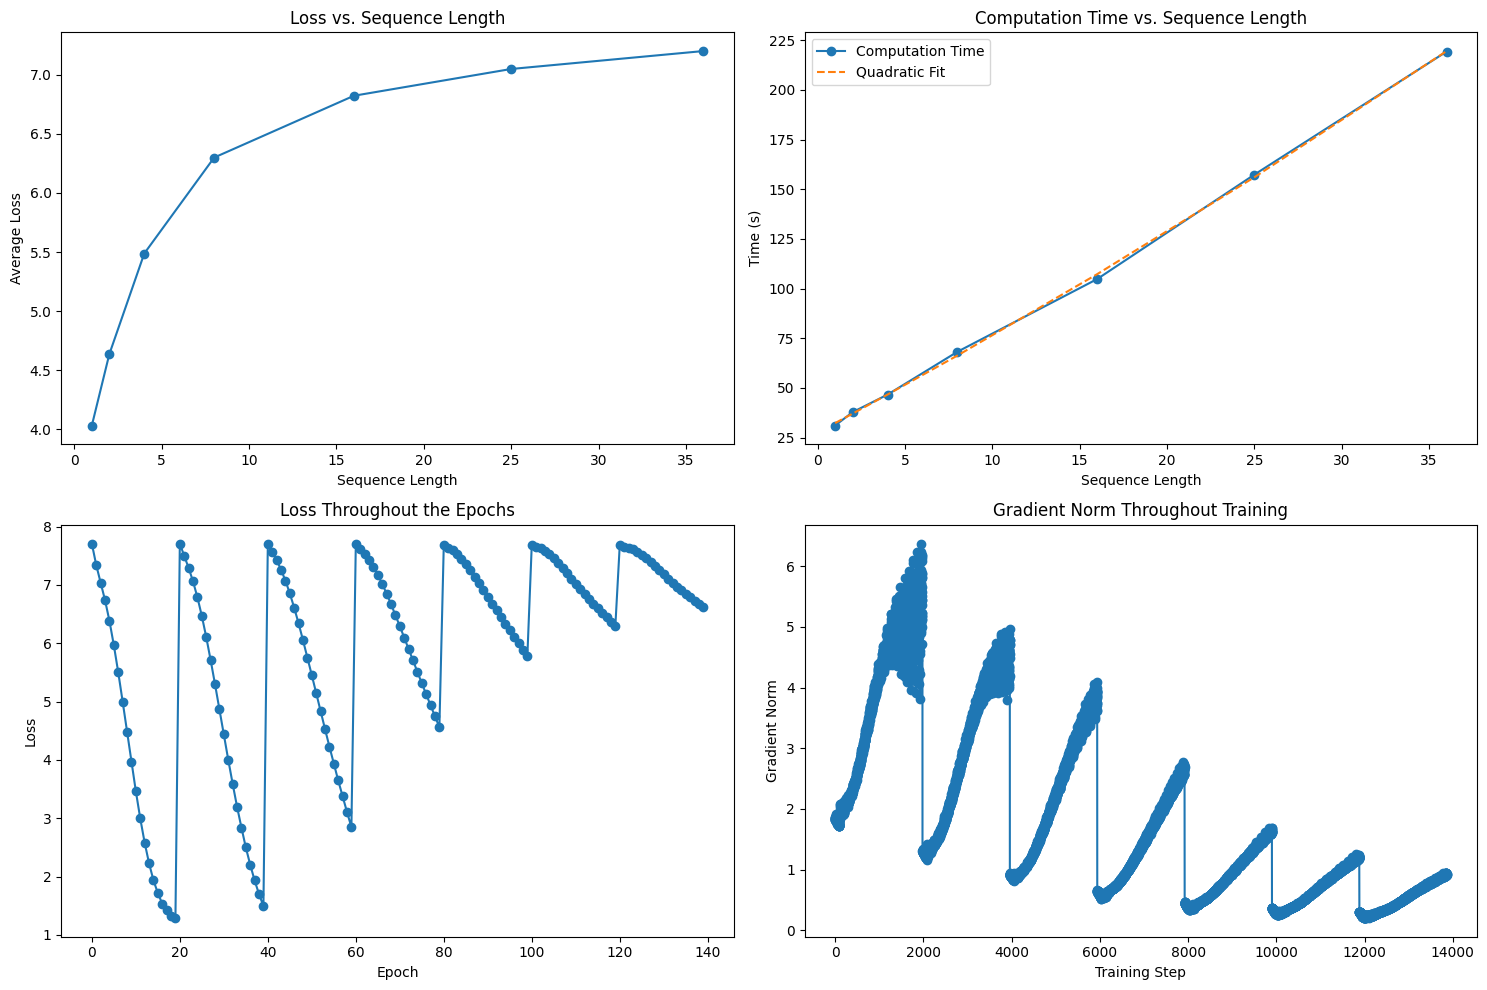

In [ ]:
# Define model parameters
dim = 128
depth = 1
num_epochs = 20  # Increased number of epochs for better training
batch_size = 32
learning_rate = 3e-4  # Adjusted learning rate ; 3e-4 not bad
head_num = 8
sequence_lengths = [1, 2, 4, 8, 16, 25, 36]  # Sequence lengths to test

# Lists to store results
losses = []
times = []
epoch_losses = []
gradient_norms = []

# for inputs, targets in train_ds.take(1):
#     print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
#     print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
#     print(f"targets.shape: {targets.shape}")


# Training loop for different sequence lengths
for max_seq_len in sequence_lengths:

    # Vectorization
    eng_vectorization = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        output_sequence_length=max_seq_len,
    )
    spa_vectorization = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        output_sequence_length=max_seq_len + 1,
        standardize=custom_standardization,
    )
    train_eng_texts = [pair[0] for pair in train_pairs]
    train_spa_texts = [pair[1] for pair in train_pairs]
    eng_vectorization.adapt(train_eng_texts)
    spa_vectorization.adapt(train_spa_texts)

    train_ds = make_dataset(train_pairs)
    val_ds = make_dataset(val_pairs)

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TransformerLM(vocab_size, dim, depth, max_seq_len, head_num, dropout=0.1).to(device)

    # Define loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)  # Learning rate scheduler

    # Generate dummy data for the given sequence length
    ids = torch.randint(0, vocab_size, (batch_size, max_seq_len * 100)).to(device)  # Adjust size as needed
    num_batches = ids.size(1) // max_seq_len

    print(f"Sequence Length: {max_seq_len}, Num Batches: {num_batches}")

    # Train the model
    start_time = time.time()
    total_loss = 0

    for epoch in range(num_epochs):
        epoch_loss = 0
        model.train()  # Ensure the model is in training mode
        for i in range(0, ids.size(1) - max_seq_len, max_seq_len):
            # Get mini-batches
            inputs = ids[:, i:i + max_seq_len].to(device)
            targets = ids[:, (i + 1):(i + 1) + max_seq_len].to(device)

            # Forward pass
            input_lengths = (torch.ones(batch_size) * max_seq_len).to(torch.int32)  # A tensor of the same length for each sequence
            outputs = model(inputs)  # Process TransformerLM's forward method
            output_flat = outputs.view(-1, vocab_size)  # Reshaped

            # Backward pass
            loss = criterion(output_flat, targets.reshape(-1))

            optimizer.zero_grad()
            loss.backward()

            # Calculate gradient norm
            total_norm = 0
            for param in model.parameters():
                if param.grad is not None:
                    param_norm = param.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            gradient_norms.append(total_norm)

            clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()

            total_loss += loss.item()
            epoch_loss += loss.item()

        epoch_losses.append(epoch_loss / num_batches)
        scheduler.step(epoch_loss / num_batches)  # Adjust learning rate based on validation loss

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / num_batches}")

    elapsed_time = time.time() - start_time
    avg_loss = total_loss / (num_batches * num_epochs)
    losses.append(avg_loss)
    times.append(elapsed_time)

    print(f"Sequence Length: {max_seq_len}, Avg Loss: {avg_loss}, Time: {elapsed_time}")

print("\n")
print(f"Total time: {sum(times)} seconds")
print("\n")

# Plotting
plt.figure(figsize=(15, 10))

quadratic_fit = np.polyfit(sequence_lengths, times, 2)
quadratic_fit_fn = np.poly1d(quadratic_fit)

# Plot Loss vs. Sequence Length
plt.subplot(2, 2, 1)
plt.plot(sequence_lengths, losses, marker='o')
plt.xlabel('Sequence Length')
plt.ylabel('Average Loss')
plt.title('Loss vs. Sequence Length')

# Plot Computation Time vs. Sequence Length
plt.subplot(2, 2, 2)
plt.plot(sequence_lengths, times, marker='o', label='Computation Time')
plt.plot(sequence_lengths, quadratic_fit_fn(sequence_lengths), label='Quadratic Fit', linestyle='--')
plt.xlabel('Sequence Length')
plt.ylabel('Time (s)')
plt.title('Computation Time vs. Sequence Length')
plt.legend()

# Plot Loss Throughout the Epochs
plt.subplot(2, 2, 3)
plt.plot(range(len(epoch_losses)), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Throughout the Epochs')

# Plot Gradient Norm Throughout Training
plt.subplot(2, 2, 4)
plt.plot(range(len(gradient_norms)), gradient_norms, marker='o')
plt.xlabel('Training Step')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norm Throughout Training')

plt.tight_layout()
plt.show()
